### Adicionando dependencias

In [1]:
import nltk.translate.bleu_score as bleu
import nltk.translate.gleu_score as gleu
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression
%matplotlib inline

import seaborn as sns
import pandas as pd

### Adicionando função para avaliar o wer_score

In [2]:
def wer_score(hyp, ref, print_matrix=False):
  N = len(hyp)
  M = len(ref)
  L = np.zeros((N,M))
  for i in range(0, N):
    for j in range(0, M):
      if min(i,j) == 0:
        L[i,j] = max(i,j)
      else:
        deletion = L[i-1,j] + 1
        insertion = L[i,j-1] + 1
        sub = 1 if hyp[i] != ref[j] else 0
        substitution = L[i-1,j-1] + sub
        L[i,j] = min(deletion, min(insertion, substitution))
        # print("{} - {}: del {} ins {} sub {} s {}".format(hyp[i], ref[j], deletion, insertion, substitution, sub))
  if print_matrix:
    print("WER matrix ({}x{}): ".format(N, M))
    print(L)
  return int(L[N-1, M-1])

### Lendo os resultados

In [3]:
file = open('results/idh_very_high_2019_09_02_monit.json', 'r')
base_very_high = json.load(file)
file.close()

file = open('results/idh_high_2019_09_02_monit.json', 'r')
base_high = json.load(file)
file.close()

file = open('results/idh_medium_2019_09_02_monit.json', 'r')
base_medium = json.load(file)
file.close()

file = open('results/idh_low_2019_09_02_monit.json', 'r')
base_low = json.load(file)
file.close()

file = open('results/idh_2019_09_12_monit.json', 'r')
base_all = json.load(file)
file.close()

### Adicionando funções para visualizar resultados

In [4]:
def plotData(history, title, ax, log = False, x = None, size = None,
             regression = False, ylabel = 'Pontuação', xlabel = True,
             smog_hists = None, linewidth = 3.5):
    if smog_hists is not None:
        ys = smog_hists
        xs = []
        for y_ in ys:
            sz = len(y_)
            xs.append(np.arange(sz))
        for i in range(len(ys)):
            y_, x_ = [ys[i], xs[i]]
            ax.plot(x_, y_, linewidth = 1, color = 'grey', alpha = 0.6)
    sz = size
    if sz is None:
        sz = len(history)
    #ax.figure(figsize = (13,7))
    
    y = history[0:sz]
    if log:
        y = -np.log(y)
    if x is None:
        x = np.arange(0, len(y))
    if regression:
        y_temp = y.reshape(-1,1)
        x_temp = x.reshape(-1,1)
        reg = LinearRegression()
        reg.fit(x_temp, y_temp)
        lin_x = np.linspace(0,sz-1).reshape(-1,1)
        lin_y = reg.predict(lin_x)
        ax.plot(lin_x, lin_y, '--', linewidth = 1, color = 'purple')
    ax.plot(x, y, marker = '^', markerfacecolor = 'purple',
             linewidth = linewidth, markersize = 4, color = 'coral')
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel('Iterações')
    if log:
        ax.set_ylabel(['-log[',ylabel,']'])
    else:
        ax.set_ylabel(ylabel)
    #plt.grid()
    #ax.show()

In [5]:
def plotData2(ys, title, legends = None, ylabel = 'Pontuação'):
    xs = []
    for y in ys:
        size = len(y)
        xs.append(np.arange(size))
    for i in range(len(ys)):
        y, x = [ys[i], xs[i]]
        plt.plot(x, y, linewidth = 2)
    plt.ylabel(ylabel)
    plt.xlabel('Iterações')
    plt.title(title)
    if legends is not None:
        plt.legend(legends)

In [6]:
def plotData3(y, title, legends = None, ylabel = 'Pontuação', linewidth = 3.5):
    x = np.arange(len(y))
    plt.plot(x, y, marker = '^', markerfacecolor = 'purple', linewidth = linewidth, markersize = 4, color = 'coral')
    plt.ylabel(ylabel)
    plt.xlabel('Iterações')
    plt.title(title)
    if legends is not None:
        plt.legend(legends)

### Visualização do acumulado

In [7]:
def accHistory(data, kind = 'GLEU'):
    size = len(data)
    hist = []
    reference = data[0]['Text_en']
    
    for i in range(size):
        hypothesis = data[i]['Text_en']
        if kind == 'GLEU':
            hist.append(gleu.sentence_gleu([reference], hypothesis))
        elif kind == 'BLEU':
            hist.append(bleu.sentence_bleu([reference], hypothesis))
        elif kind == 'WER':
            hist.append(wer_score(hypothesis.split(), reference.split(), print_matrix = False))
        else:
            print('ERRO: Kind not valid!')
            return -1
    return np.asarray(hist)

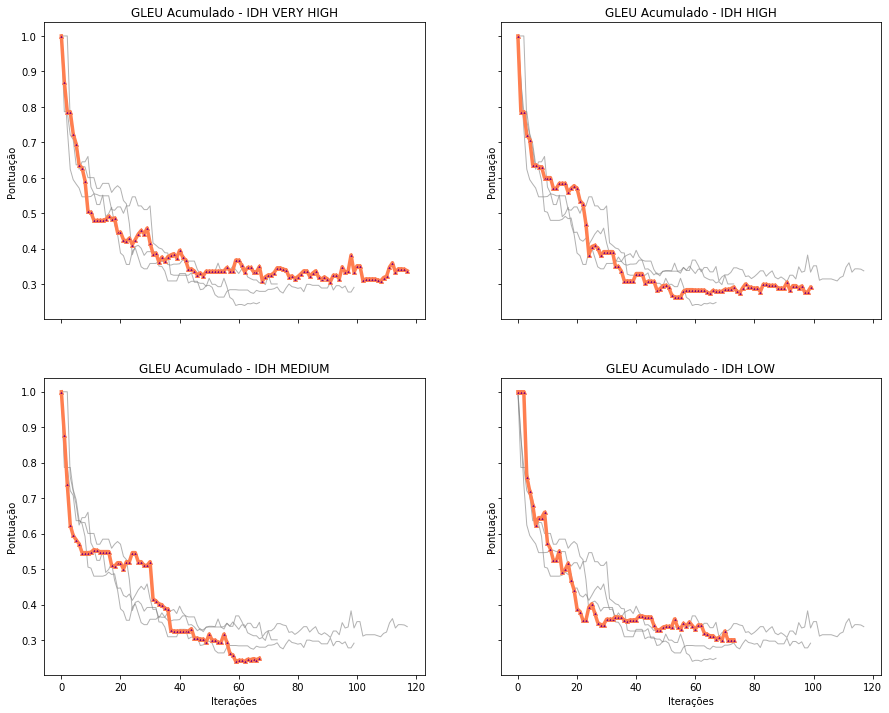

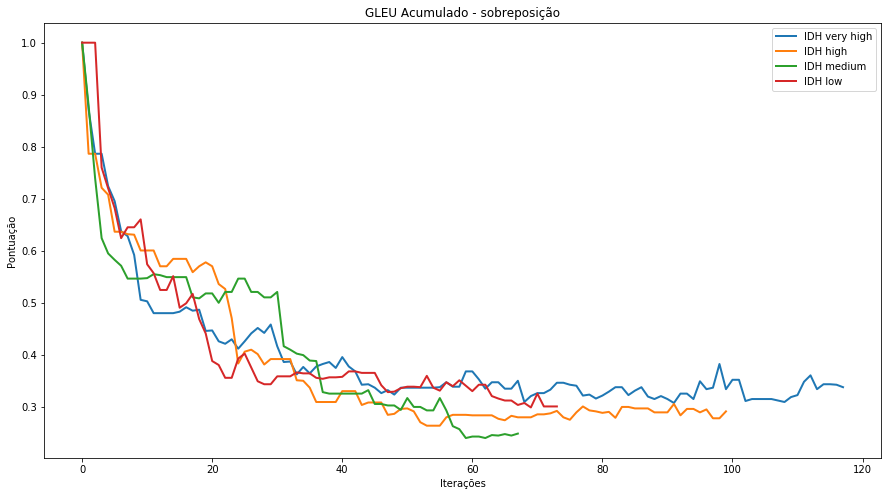

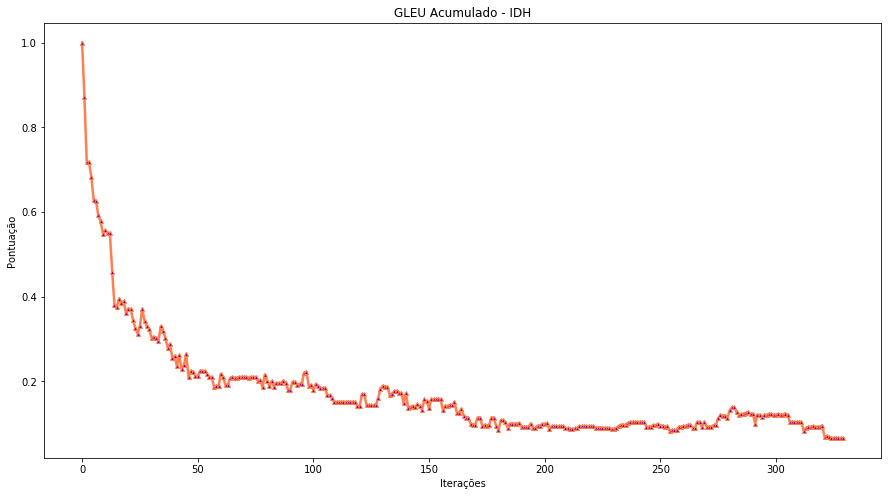

In [8]:
gleu_hist_very_high = accHistory(base_very_high, 'GLEU')
gleu_hist_high = accHistory(base_high, 'GLEU')
gleu_hist_medium = accHistory(base_medium, 'GLEU')
gleu_hist_low = accHistory(base_low, 'GLEU')
gleu_hist_all = accHistory(base_all, 'GLEU')
histories = [gleu_hist_very_high, gleu_hist_high, gleu_hist_medium, gleu_hist_low]

f, axs = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,12))
plotData(gleu_hist_very_high, 'GLEU Acumulado - IDH VERY HIGH', axs[0,0],
         xlabel = False, smog_hists = histories)
plotData(gleu_hist_high, 'GLEU Acumulado - IDH HIGH', axs[0,1],
         xlabel = False, smog_hists = histories)
plotData(gleu_hist_medium, 'GLEU Acumulado - IDH MEDIUM', axs[1,0], xlabel = True,
         smog_hists = histories)
plotData(gleu_hist_low, 'GLEU Acumulado - IDH LOW', axs[1,1], xlabel = True,
         smog_hists = histories)

plt.figure(figsize=(15,8))
plotData2(histories, 'GLEU Acumulado - sobreposição', legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(gleu_hist_all, 'GLEU Acumulado - IDH', linewidth = 2.5)

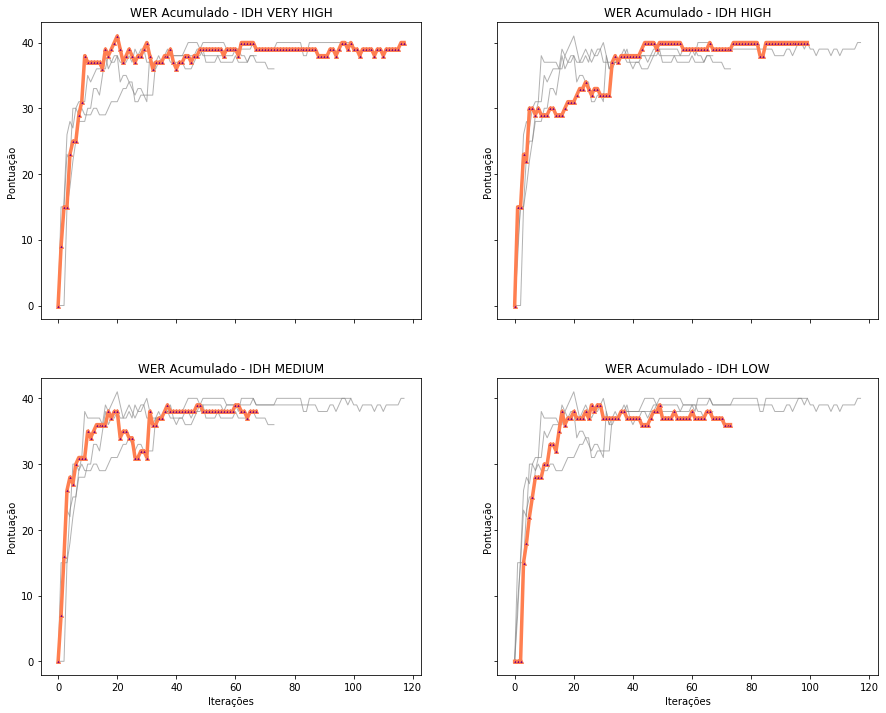

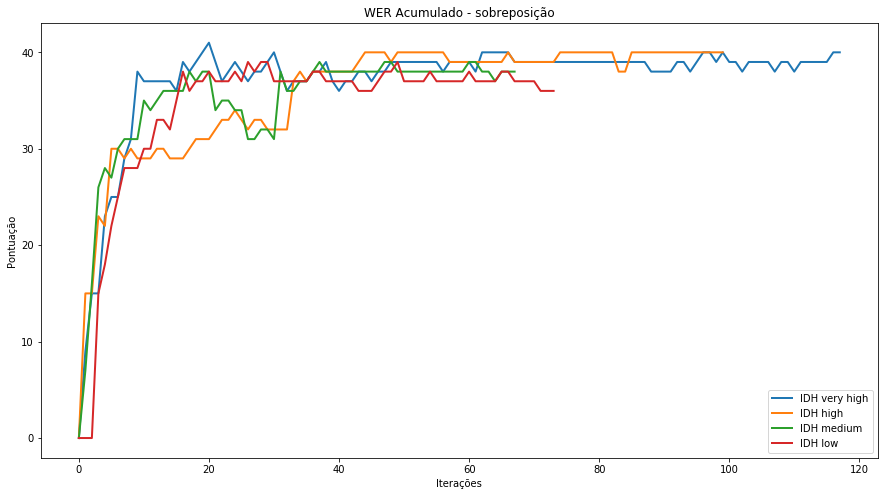

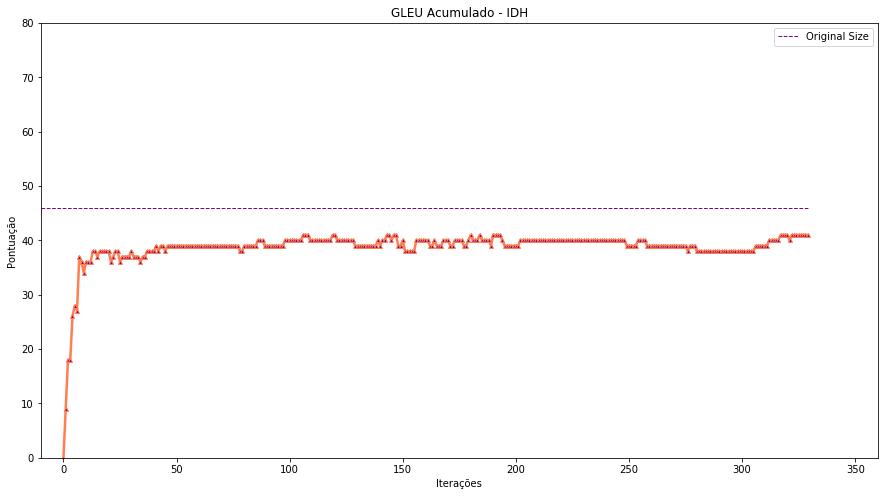

In [9]:
wer_hist_very_high = accHistory(base_very_high, 'WER')
wer_hist_high = accHistory(base_high, 'WER')
wer_hist_medium = accHistory(base_medium, 'WER')
wer_hist_low = accHistory(base_low, 'WER')
wer_hist_all = accHistory(base_all, 'WER')
histories = [wer_hist_very_high, wer_hist_high, wer_hist_medium, wer_hist_low]

f, axs = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,12))
plotData(wer_hist_very_high, 'WER Acumulado - IDH VERY HIGH', axs[0,0],
         xlabel = False, smog_hists = histories)
plotData(wer_hist_high, 'WER Acumulado - IDH HIGH', axs[0,1],
         xlabel = False, smog_hists = histories)
plotData(wer_hist_medium, 'WER Acumulado - IDH MEDIUM', axs[1,0], xlabel = True,
         smog_hists = histories)
plotData(wer_hist_low, 'WER Acumulado - IDH LOW', axs[1,1], xlabel = True,
         smog_hists = histories)

plt.figure(figsize=(15,8))
plotData2(histories, 'WER Acumulado - sobreposição', legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(wer_hist_all, 'GLEU Acumulado - IDH', linewidth = 2.5)
ref_size = len(base_all[0]['Text_origin'].split())
plt.plot(np.arange(-10,len(wer_hist_all)), ref_size*np.ones(len(wer_hist_all)+10), '--', color = 'purple',
         linewidth = 1, label='Original Size')
plt.axis([-10, 360, 0, 80])
plt.legend()

### Visualização do passo a passo

In [18]:
def papHistory(data, kind = 'GLEU'):
    size = len(data)
    hist = []
    x = []
    j = 0
    for i in range(size-1):
        reference = data[i]['Text_en']
        hypothesis = data[i+1]['Text_en']
        score = 0
        if kind == 'GLEU':
            score = gleu.sentence_gleu([reference], hypothesis)
        elif kind == 'BLEU':
            score = bleu.sentence_bleu([reference], hypothesis)
        elif kind == 'WER':
            score = wer_score(hypothesis.split(), reference.split(), print_matrix = False)
        else:
            print('ERRO: Kind not valid!')
            return -1
        j += 1
        x.append(i)
        hist.append(score)
    return np.asarray(hist), np.asarray(x)

In [19]:
def findOutliers(data, hist, x = None, n = 5, kind = 'GLEU'):
    sz = len(hist)
    if x is None:
        x = np.arange(sz)
    pairs = []
    for i in range(sz):
        pairs.append([hist[i], x[i]])
    pairs.sort(key=lambda tup: tup[0])
    ansy = []
    ansx = []
    if kind == 'GLEU' or kind == 'BLEU':
        k = 0;
        for i in range(n):
            ansy.append(pairs[k][0])
            ansx.append(pairs[k][1])
            k += 1
    elif kind == 'WER':
        k = sz-1;
        for i in range(n):
            ansy.append(pairs[k][0])
            ansx.append(pairs[k][1])
            k -= 1
    else:
        print('ERRO: Kind not valid!')
        return -1
    legends = []
    for i in range(n):
        legends.append(data[ansx[i]-1]['Code']+' - '+data[ansx[i]]['Code'])
    return np.asarray(ansx), np.asarray(ansy), legends

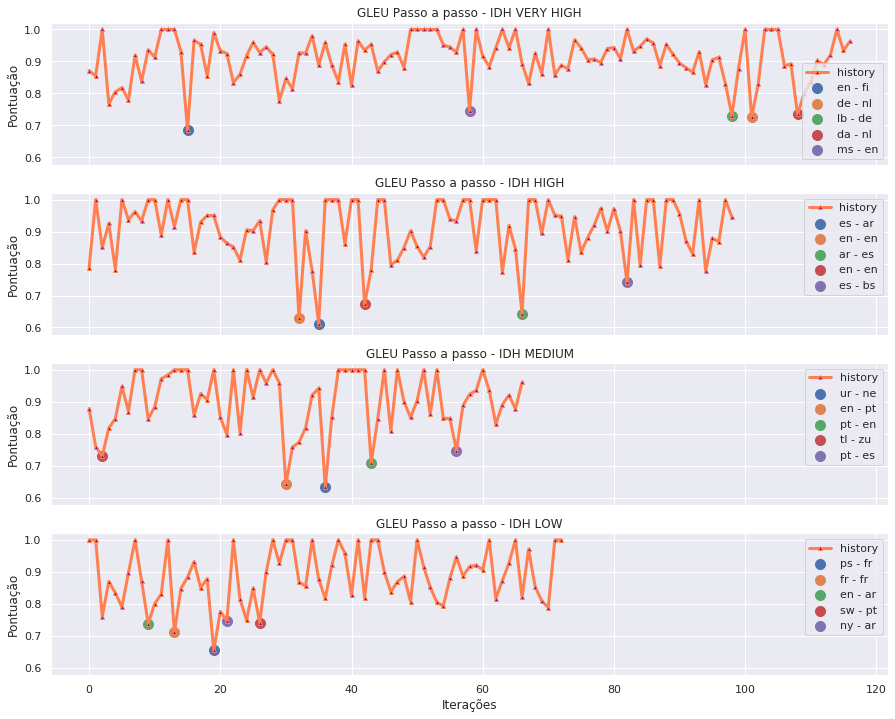

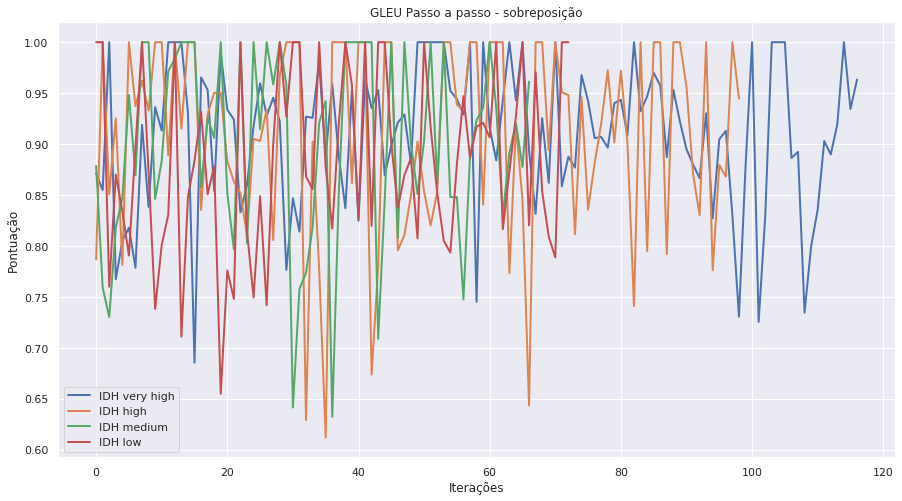

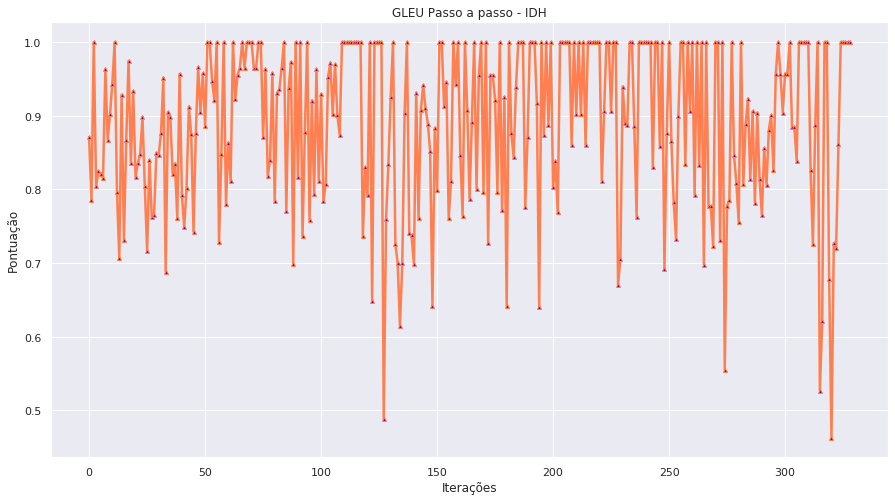

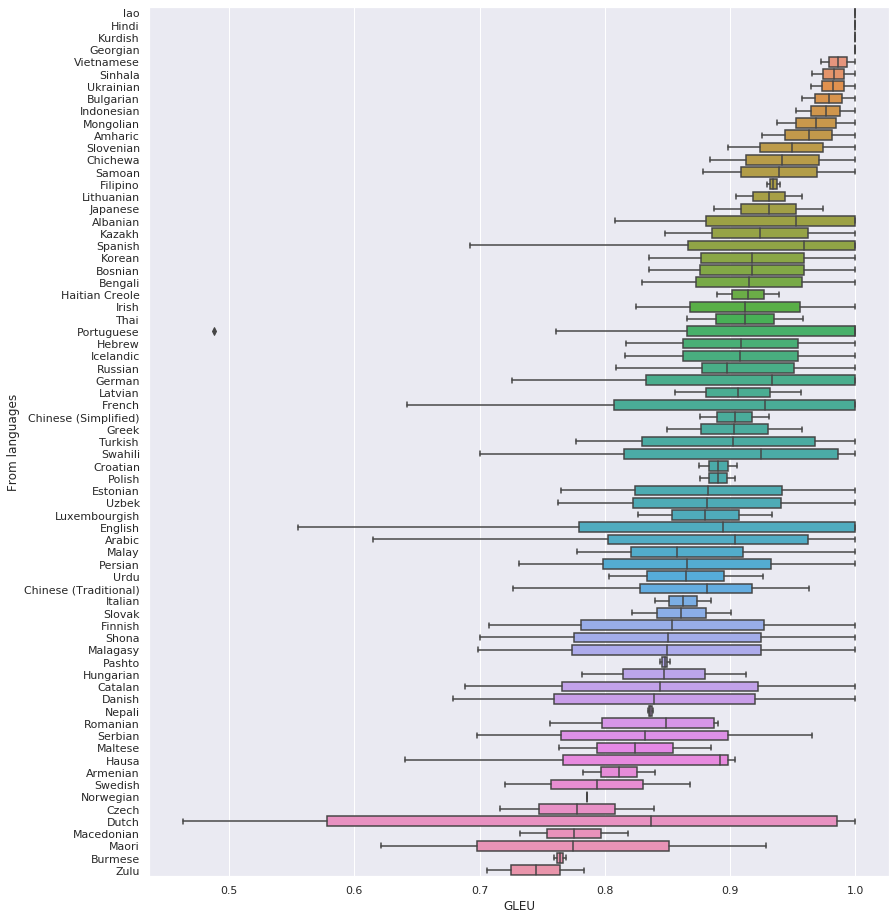

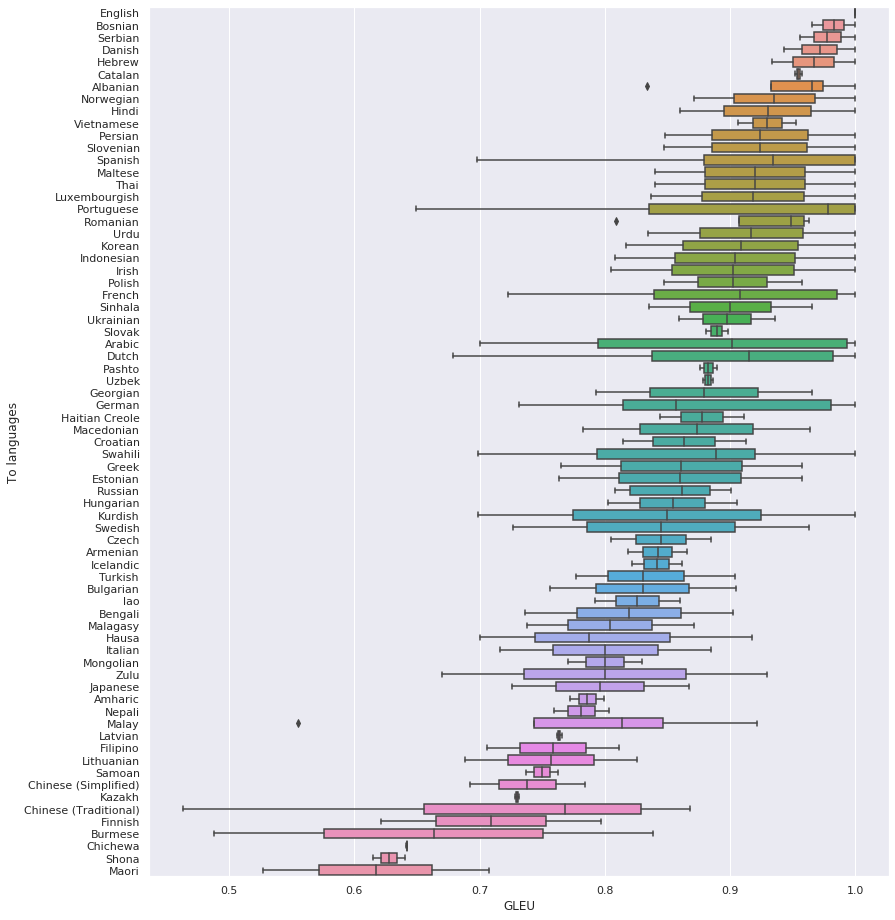

In [22]:
gleu_hist_very_high, x_vh = papHistory(base_very_high, 'GLEU')
gleu_hist_high, x_h = papHistory(base_high, 'GLEU')
gleu_hist_medium, x_m = papHistory(base_medium, 'GLEU')
gleu_hist_low, x_l = papHistory(base_low, 'GLEU')
gleu_hist_all, x_all = papHistory(base_all, 'GLEU')
histories = [gleu_hist_very_high, gleu_hist_high, gleu_hist_medium, gleu_hist_low]

f, axs = plt.subplots(4, 1, sharey = True, sharex = True, figsize=(15,12))
plotData(gleu_hist_very_high, 'GLEU Passo a passo - IDH VERY HIGH', axs[0],
         xlabel = False, x = x_vh, linewidth = 3)

x, y, leg = findOutliers(base_very_high, gleu_hist_very_high, x = x_vh)
leg.insert(0, 'history')
for i in range(len(x)):
    axs[0].scatter(x[i], y[i], s = 100)
axs[0].legend(leg)

plotData(gleu_hist_high, 'GLEU Passo a passo - IDH HIGH', axs[1],
         xlabel = False, x = x_h, linewidth = 3)

x, y, leg = findOutliers(base_high, gleu_hist_high, x = x_h)
leg.insert(0, 'history')
for i in range(len(x)):
    axs[1].scatter(x[i], y[i], s = 100)
axs[1].legend(leg)

plotData(gleu_hist_medium, 'GLEU Passo a passo - IDH MEDIUM', axs[2], xlabel = False,
         x = x_m, linewidth = 3)

x, y, leg = findOutliers(base_medium, gleu_hist_medium, x = x_m)
leg.insert(0, 'history')
for i in range(len(x)):
    axs[2].scatter(x[i], y[i], s = 100)
axs[2].legend(leg)

plotData(gleu_hist_low, 'GLEU Passo a passo - IDH LOW', axs[3], xlabel = True,
        x = x_l, linewidth = 3)

x, y, leg = findOutliers(base_low, gleu_hist_low, x = x_l)
leg.insert(0, 'history')
for i in range(len(x)):
    axs[3].scatter(x[i], y[i], s = 100)
axs[3].legend(leg)

plt.figure(figsize=(15,8))
plotData2(histories, 'GLEU Passo a passo - sobreposição', legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(gleu_hist_all, 'GLEU Passo a passo - IDH', linewidth = 2.5)


codes = []
langs = []
for i in range(len(base_all)): 
    codes.append(base_all[i]['Code'])
    langs.append(base_all[i]['Language'])
from_codes = []
from_langs = []
to_codes = []
to_langs = []
for i in range(len(codes)-1):
    from_codes.append(codes[i])
    to_codes.append(codes[i+1])
    from_langs.append(langs[i])
    to_langs.append(langs[i+1])

all_df = pd.DataFrame({'GLEU': gleu_hist_all, 'From codes': from_codes, 'To codes': to_codes,
          'From languages': from_langs, 'To languages': to_langs})

plt.figure(figsize=(13.25,16))
sns.set()
ranks = all_df.groupby('From languages')['GLEU'].mean().sort_values(ascending = True)[::-1].index
sns.boxplot(data = all_df, y = 'From languages', x = all_df['GLEU'], order = ranks)
plt.figure(figsize=(13.25,16))
sns.set()
ranks = all_df.groupby('To languages')['GLEU'].mean().sort_values(ascending = True)[::-1].index
sns.boxplot(data = all_df, y = 'To languages', x = all_df['GLEU'], order = ranks)

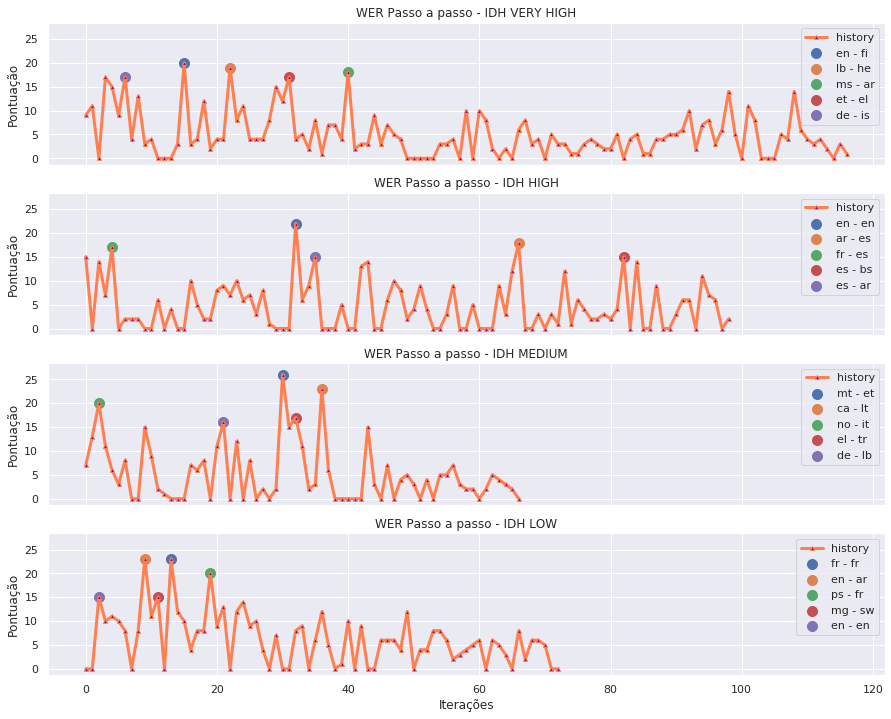

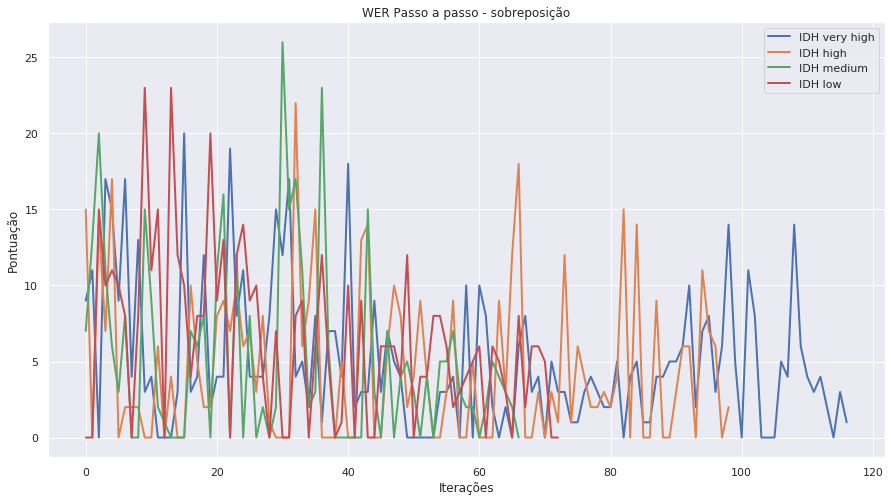

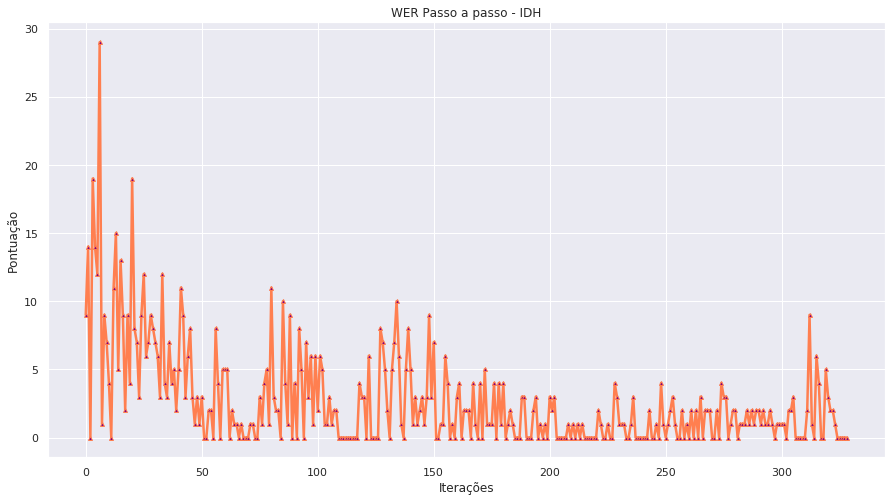

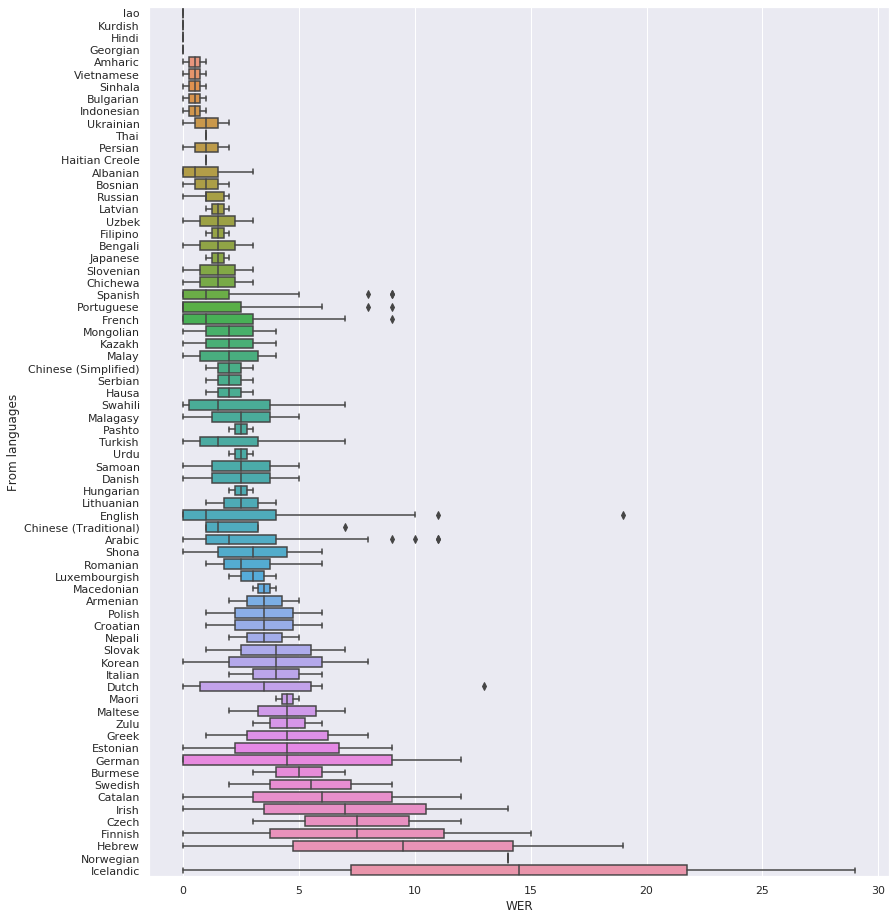

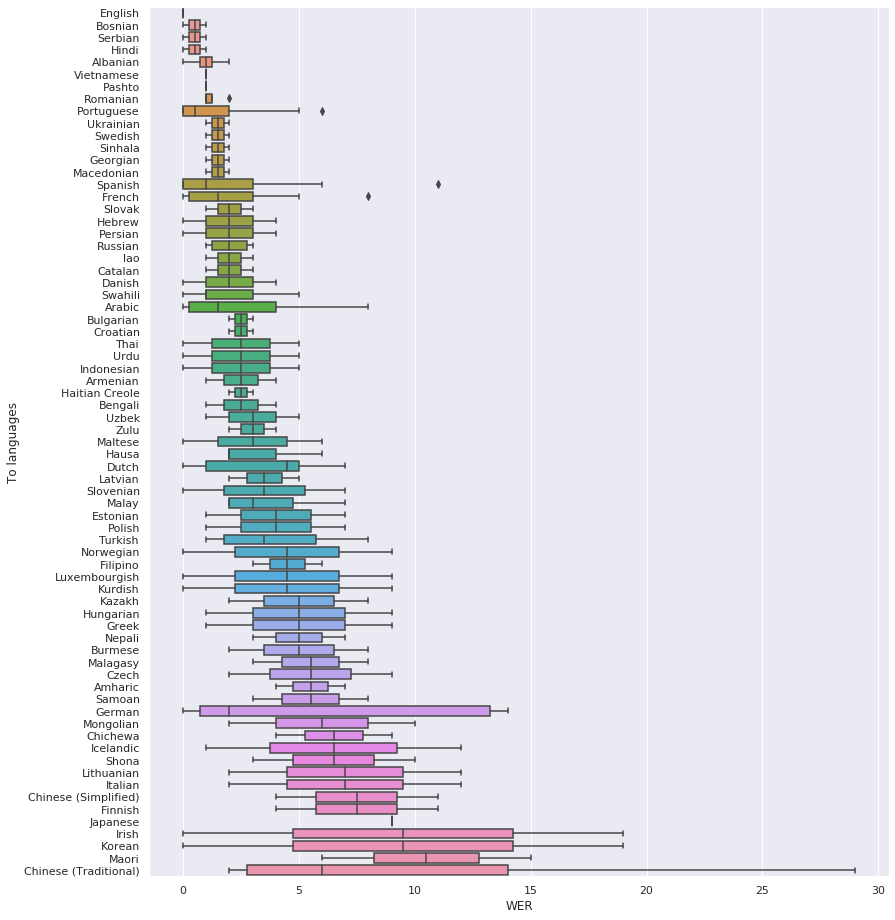

In [24]:
wer_hist_very_high, x_vh = papHistory(base_very_high, 'WER')
wer_hist_high, x_h = papHistory(base_high, 'WER')
wer_hist_medium, x_m = papHistory(base_medium, 'WER')
wer_hist_low, x_l = papHistory(base_low, 'WER')
wer_hist_all, x_all = papHistory(base_all, 'WER')
histories = [wer_hist_very_high, wer_hist_high, wer_hist_medium, wer_hist_low]

f, axs = plt.subplots(4, 1, sharey = True, sharex = True, figsize=(15,12))
plotData(wer_hist_very_high, 'WER Passo a passo - IDH VERY HIGH', axs[0],
         xlabel = False, x = x_vh, linewidth = 3)

x, y, leg = findOutliers(base_very_high, wer_hist_very_high, x = x_vh, kind = 'WER')
leg.insert(0, 'history')
for i in range(len(x)):
    axs[0].scatter(x[i], y[i], s = 100)
axs[0].legend(leg)

plotData(wer_hist_high, 'WER Passo a passo - IDH HIGH', axs[1],
         xlabel = False, x = x_h, linewidth = 3)

x, y, leg = findOutliers(base_high, wer_hist_high, x = x_h, kind = 'WER')
leg.insert(0, 'history')
for i in range(len(x)):
    axs[1].scatter(x[i], y[i], s = 100)
axs[1].legend(leg)

plotData(wer_hist_medium, 'WER Passo a passo - IDH MEDIUM', axs[2], xlabel = False,
         x = x_m, linewidth = 3)

x, y, leg = findOutliers(base_very_high, wer_hist_medium, x = x_m, kind = 'WER')
leg.insert(0, 'history')
for i in range(len(x)):
    axs[2].scatter(x[i], y[i], s = 100)
axs[2].legend(leg)

plotData(wer_hist_low, 'WER Passo a passo - IDH LOW', axs[3], xlabel = True,
        x = x_l, linewidth = 3)

x, y, leg = findOutliers(base_low, wer_hist_low, x = x_l, kind = 'WER')
leg.insert(0, 'history')
for i in range(len(x)):
    axs[3].scatter(x[i], y[i], s = 100)
axs[3].legend(leg)

plt.figure(figsize=(15,8))
plotData2(histories, 'WER Passo a passo - sobreposição', legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(wer_hist_all, 'WER Passo a passo - IDH', linewidth = 2.5)
'''
codes = []
langs = []
for i in range(len(base_all)): 
    codes.append(base_all[i]['Code'])
    langs.append(base_all[i]['Language'])
from_codes = []
from_langs = []
to_codes = []
to_langs = []
for i in range(len(codes)-1):
    from_codes.append(codes[i])
    to_codes.append(codes[i+1])
    from_langs.append(langs[i])
    to_langs.append(langs[i+1])

all_df = pd.DataFrame({'WER': wer_hist_all, 'From codes': from_codes, 'To codes': to_codes,
          'From languages': from_langs, 'To languages': to_langs})
'''
all_df['WER'] = wer_hist_all

plt.figure(figsize=(13.25,16))
sns.set()
ranks = all_df.groupby('From languages')['WER'].mean().sort_values(ascending = False)[::-1].index
sns.boxplot(data = all_df, y = 'From languages', x = all_df['WER'], order = ranks)
plt.figure(figsize=(13.25,16))
sns.set()
ranks = all_df.groupby('To languages')['WER'].mean().sort_values(ascending = False)[::-1].index
sns.boxplot(data = all_df, y = 'To languages', x = all_df['WER'], order = ranks)

### Visualização do tamanho do texto

In [25]:
def tamHistory(data):
    size = len(data)
    hist = []
    for i in range(size):
        hist.append(len(data[i]['Text_en'].split()))
    return np.asarray(hist)

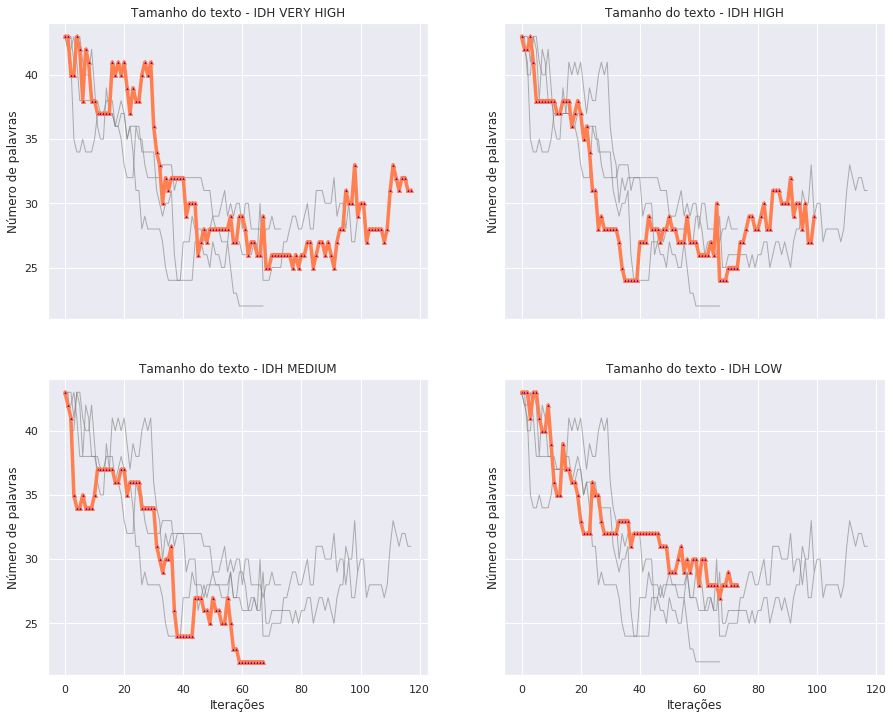

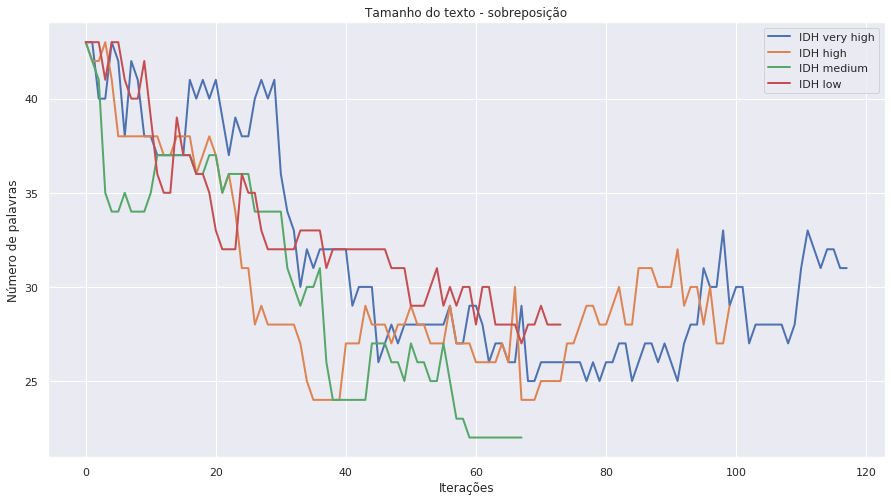

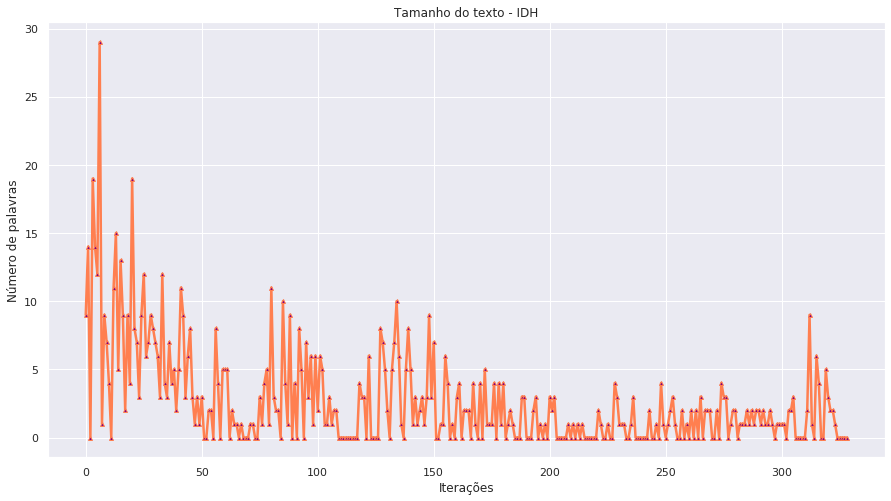

In [26]:
tam_hist_very_high = tamHistory(base_very_high)
tam_hist_high = tamHistory(base_high)
tam_hist_medium = tamHistory(base_medium)
tam_hist_low = tamHistory(base_low)
tam_hist_all = tamHistory(base_all)
histories = [tam_hist_very_high, tam_hist_high, tam_hist_medium, tam_hist_low]

f, axs = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,12))
plotData(tam_hist_very_high, 'Tamanho do texto - IDH VERY HIGH', axs[0,0],
         xlabel = False, smog_hists = histories, ylabel = 'Número de palavras')
plotData(tam_hist_high, 'Tamanho do texto - IDH HIGH', axs[0,1],
         xlabel = False, smog_hists = histories, ylabel = 'Número de palavras')
plotData(tam_hist_medium, 'Tamanho do texto - IDH MEDIUM', axs[1,0], xlabel = True,
         smog_hists = histories, ylabel = 'Número de palavras')
plotData(tam_hist_low, 'Tamanho do texto - IDH LOW', axs[1,1], xlabel = True,
         smog_hists = histories, ylabel = 'Número de palavras')

plt.figure(figsize=(15,8))
plotData2(histories, 'Tamanho do texto - sobreposição', ylabel = 'Número de palavras',
          legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(wer_hist_all, 'Tamanho do texto - IDH', ylabel = 'Número de palavras', linewidth = 2.5)

In [31]:
base_all[4]

{'Text_origin': 'Dóibh féin, tabharfaidh aon léamh ar théacs méid nua agus tuiscint nua ar an téacs seo i gcónaí. Go hachomair, labhraíonn sé le téacsanna mar Heraclitus River Bather, nach féidir leat a chur isteach faoi dhó toisc go bhfuil an cúrsa ag athrú i gcónaí.',
 'Text_en': 'For themselves, any reading of a new size text and a new understanding of this text will always. In short, he speaks to texts such as Heraclitus River Bather, which you cannot insert twice because the course is constantly changing.',
 'Code': 'ga',
 'Language': 'Irish'}